In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import onnx
from onnx_tf.backend import prepare
import h5py
plt.style.use("ggplot")

In [3]:
## Load datasets
combined_data = h5py.File("h5_datasets/combined_CT_datasets.h5", "r")

## Get train and test datasets
label_y = np.array(combined_data["label_test"])
y = np.array(combined_data["y"])

# predict using ONXX model trained remotely

#loaded_model = onnx.load("galaxy_trained_model/galaxy_trained_model_2.onnx") #onnx.load("onnx_loaded_model1/ct_seg_model.onnx")
# https://usegalaxy.eu/api/histories/d83af45c42c55bdb/contents/11ac94870d0bb33aa573fa238dbeaacd/display
## download data from Galaxy history

#path_trained_model = "https://usegalaxy.eu/api/histories/d83af45c42c55bdb/contents/11ac94870d0bb33aa573fa238dbeaacd/display"
#if not os.path.exists('galaxy_trained_model'):
#    os.makedirs('galaxy_trained_model')

# Write to an onnx file
# Get trained model
#r = requests.get(path_tm, allow_redirects=True)
#open('galaxy_trained_model/galaxy_trained_model_2.onnx', 'wb').write(r.content)
#loaded_model = onnx.load("galaxy_trained_model/galaxy_trained_model_2.onnx")

# predict using ONXX trained model
loaded_model = onnx.load("onnx_trained_model/ct_seg_model.onnx")

tf_loaded_model = prepare(loaded_model)
prediction_onnx = tf_loaded_model.run(y, training=False)
prediction_onnx = np.array(prediction_onnx).squeeze()

onnx_preds_test_t1 = (prediction_onnx > 0.1).astype(np.uint8)
onnx_preds_test_t2 = (prediction_onnx > 0.3).astype(np.uint8)

2022-03-18 11:41:52.290888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:41:52.304918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:41:52.306661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 11:41:52.309229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
## Plot predicted masks
no_pred = 5
def plot_sample(X, y, binary_preds1, binary_preds2):
    fig, axs = plt.subplots(no_pred, 4, figsize=(80, 80),sharex='all')
    rand_indx = np.random.randint(1, y.shape[0], no_pred)
    i = 0
    for ix in rand_indx:
        l = 1
        axs[i,0].imshow(X[ix, ..., 0], cmap='gray')
        axs[0,0].set_title('Original CT Images',fontweight="bold", size=40)

        axs[i,1].imshow(y[ix,:,:,l].squeeze(),cmap='gray')
        axs[0,1].set_title('Ground-Truth Mask',fontweight="bold", size=40)

        axs[i,2].imshow(binary_preds1[ix,:,:,l].squeeze(), cmap='gray', vmin=0, vmax=1)
        axs[0,2].set_title('Predicted Mask \n with BCE loss',fontweight="bold", size=40)
      
        axs[i,3].imshow(binary_preds2[ix,:,:,l].squeeze(), cmap='gray', vmin=0, vmax=1)
        axs[0,3].set_title('Predicted Masks \n with BCE+TV Loss',fontweight="bold", size=40)
        
        i += 1
      
        plt.rcParams["axes.grid"] = False
        plt.subplots_adjust(wspace=-0.5, hspace=0.1)

    plt.savefig("true_pred_dataset2.png")

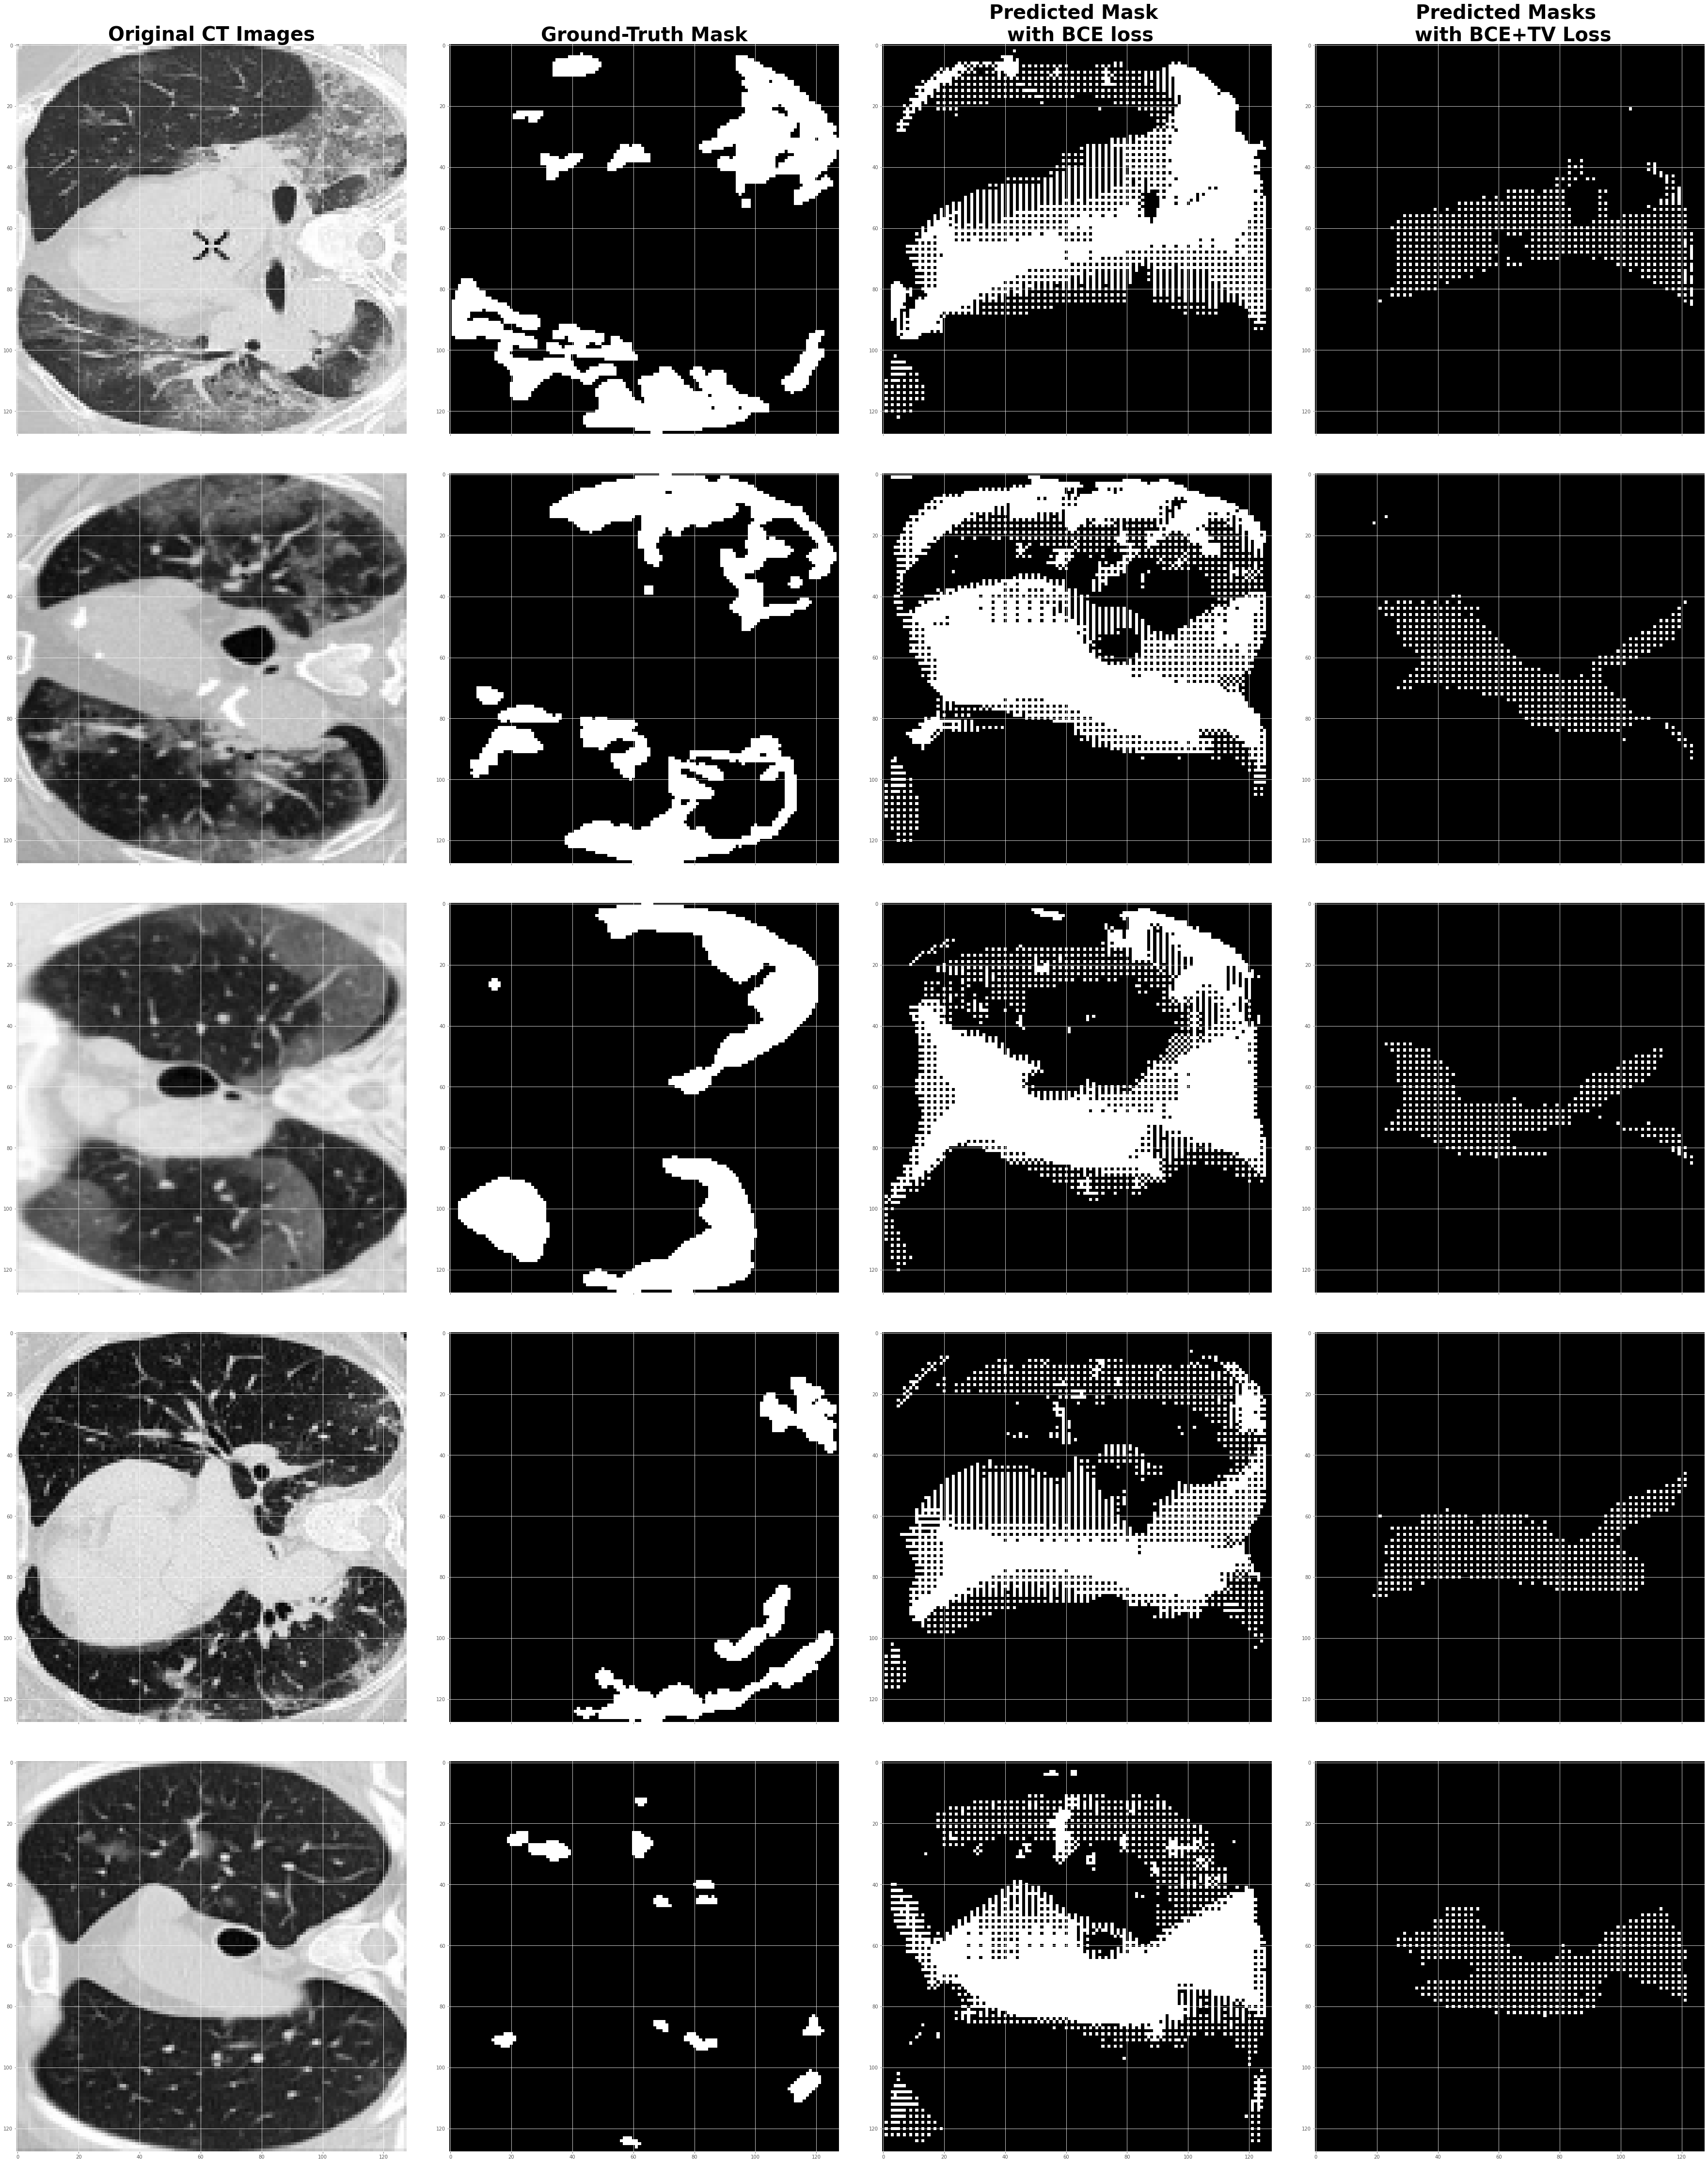

In [5]:
plot_sample(y, label_y, onnx_preds_test_t1, onnx_preds_test_t2)